In [1]:
import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import os

from pathlib import Path
import matplotlib.pyplot as plt

from timm.models import create_model
from dataset_loco import MVTecLOCO, build_loco_dataset
from einops import rearrange

import modeling_vqkd

from dataset_loco import build_loco_dataloader, build_loco_dataset

/home/sakai/projects/Reimpl/BEiTv2/unilm/beit2/modeling_finetune.py:472: UserWarning: Overwriting beit_base_patch16_224 in registry with modeling_finetune.beit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/sakai/projects/Reimpl/BEiTv2/unilm/beit2/modeling_finetune.py:488: UserWarning: Overwriting beit_base_patch16_384 in registry with modeling_finetune.beit_base_patch16_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/sakai/projects/Reimpl/BEiTv2/unilm/beit2/modeling_finetune.py:504: UserWarning: Overwriting beit_large_patch16_224 in registry with modeling_finetune.beit_large_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/home/sakai/projects/Reimpl/BEiTv2/unilm/beit2/modeling_finetune.py:513

In [2]:
def get_args(arg_list: list):
    parser = argparse.ArgumentParser('BEiT pre-training script', add_help=False)
    parser.add_argument('--batch_size', default=1, type=int)
    parser.add_argument('--epochs', default=100, type=int)
    parser.add_argument('--save_ckpt_freq', default=20, type=int)
    # Model parameters
    parser.add_argument('--model', default='vqkd_encoder_base_decoder_3x768x12_clip', type=str, metavar='MODEL',  help='Name of model to train')  
    parser.add_argument('--category', default='bottle', type=str, help='category of dataset')
    parser.add_argument('--rec_loss_type', default='cosine', type=str, metavar='MODEL',
                        help='type of loss to calculate reconstruction distance')

    parser.add_argument('--codebook_n_emd', default=8192, type=int, metavar='MODEL',
                        help='number of codebook')
    parser.add_argument('--codebook_emd_dim', default=32, type=int, metavar='MODEL',
                        help='number of codebook')
    parser.add_argument('--ema_decay', default=0.99, type=float, metavar='MODEL', help='ema decay for quantizer')
    parser.add_argument('--quantize_kmeans_init', action='store_true', help='enable kmeans_init for quantizer')

    parser.add_argument('--process_type', default='default', type=str, choices=['default', 'dall-e', 'imagenet_norm'],
                        help='Image process type (default, dall-e)')
    parser.add_argument('--input_size', default=224, type=int, help='images input size for backbone')

    # regress feature
    parser.add_argument('--teacher_model_type', default='clip', type=str, help='teacher_model_type during training')
    parser.add_argument('--teacher_input_size', default=224, type=int, help='teacher_input_size for clip-large p14')

    # Optimizer parameters
    parser.add_argument('--opt', default='adamw', type=str, metavar='OPTIMIZER',
                        help='Optimizer (default: "adamw"')
    parser.add_argument('--opt_eps', default=1e-8, type=float, metavar='EPSILON',
                        help='Optimizer Epsilon (default: 1e-8)')
    parser.add_argument('--opt_betas', default=None, type=float, nargs='+', metavar='BETA',
                        help='Optimizer Betas (default: None, use opt default)')
    parser.add_argument('--clip_grad', type=float, default=None, metavar='NORM',
                        help='Clip gradient norm (default: None, no clipping)')
    parser.add_argument('--weight_decay', type=float, default=1e-4,
                        help='weight decay (default: 1e-4)')
    parser.add_argument('--weight_decay_end', type=float, default=None, help="""Final value of the
        weight decay. We use a cosine schedule for WD. 
        (Set the same value with args.weight_decay to keep weight decay no change)""")

    parser.add_argument('--lr', type=float, default=5e-5, metavar='LR',
                        help='learning rate (default: 5e-5)')
    parser.add_argument('--warmup_lr', type=float, default=1e-6, metavar='LR',
                        help='warmup learning rate (default: 1e-6)')
    parser.add_argument('--min_lr', type=float, default=1e-5, metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0 (1e-5)')

    parser.add_argument('--warmup_epochs', type=int, default=5, metavar='N',
                        help='epochs to warmup LR, if scheduler supports')
    parser.add_argument('--warmup_steps', type=int, default=-1, metavar='N',
                        help='epochs to warmup LR, if scheduler supports')

    # Augmentation parameters
    parser.add_argument('--color_jitter', type=float, default=0., metavar='PCT',
                        help='Color jitter factor (default: 0.)')
    parser.add_argument('--train_interpolation', type=str, default='bicubic',
                        help='Training interpolation (random, bilinear, bicubic, lanczos default: "bicubic")')
    parser.add_argument('--min_crop_scale', type=float, default=0.08, metavar='PCT',
                        help='min_crop_scale (default: 0.08)')

    # Dataset parameters
    parser.add_argument('--data_root', default='/datasets01/imagenet_full_size/061417/', type=str,
                        help='dataset path')
    parser.add_argument('--eval_data_path', default='', type=str, help='dataset path')
    parser.add_argument('--data_set', default='image_folder', type=str, help='dataset path')
 
    parser.add_argument('--imagenet_default_mean_and_std', default=False, action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--log_dir', default=None,
                        help='path where to tensorboard log')
    
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--auto_resume', action='store_true')
    parser.add_argument('--no_auto_resume', action='store_false', dest='auto_resume')
    parser.set_defaults(auto_resume=True)

    parser.add_argument('--dist_eval', action='store_true', default=True,
                        help='Enabling distributed evaluation')
    parser.add_argument('--disable_eval', action='store_true', default=False)
    
    parser.add_argument('--eval', action='store_true', default=False, help="Perform evaluation only")
    parser.add_argument('--calculate_codebook_usage', action='store_true', default=False)

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--num_workers', default=10, type=int)
    parser.add_argument('--pin_mem', action='store_true',
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
    parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem',
                        help='')
    parser.set_defaults(pin_mem=True)
    
    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--local_rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', action='store_true')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')

    return parser.parse_args(arg_list)

def get_default_args(category: str):
    return get_args([
        '--batch_size', '32',
        '--epochs', '500',
        '--save_ckpt_freq', '100',
        '--model', 'vqkd_encoder_base_decoder_1x768x12_dino',
        '--rec_loss_type', 'cosine',
        '--codebook_n_emd', '20',
        '--codebook_emd_dim', '32',
        '--ema_decay', '0.99',
        '--quantize_kmeans_init',
        '--process_type', 'default',
        '--input_size', '384',
        '--teacher_model_type', 'dino',
        '--teacher_input_size', '384',
        '--opt', 'adamw',
        '--opt_eps', '1e-8',
        '--opt_betas', '0.9', '0.999',
        '--clip_grad', '1.0',
        '--weight_decay', '1e-4',
        '--weight_decay_end', '1e-4',
        '--lr', '5e-5',
        '--warmup_lr', '1e-6',
        '--min_lr', '1e-5',
        '--warmup_epochs', '5',
        '--warmup_steps', '-1',
        '--color_jitter', '0.5',
        '--train_interpolation', 'bicubic',
        '--min_crop_scale', '0.08',
        '--data_root', f'/home/sakai/projects/LADMIM/LADMIM/data/mvtec_loco',
        '--category', category,
        '--eval_data_path', f'/home/sakai/projects/LADMIM/LADMIM/data/mvtec_{category}',
        '--data_set', 'loco',
        '--imagenet_default_mean_and_std',
        '--output_dir', f'/home/sakai/projects/Reimpl/BEiTv2/unilm/beit2/output/vqkd_encoder_base_decoder_1x768x12_dino_{category}',
        '--log_dir', f'/home/sakai/projects/Reimpl/BEiTv2/unilm/beit2/output/vqkd_encoder_base_decoder_1x768x12_dino_{category}',
        '--device', 'cuda',
        '--seed', '0'
    ])

def get_model(args, **kwargs):
       
    model = create_model(
        args.model,
        pretrained=False,
        as_tokenzer=False,
        n_code=args.codebook_n_emd,
        code_dim=args.codebook_emd_dim,
        img_size=args.input_size,
        rec_loss_type=args.rec_loss_type,
        teacher_model_type=args.teacher_model_type,
        teacher_input_size=args.teacher_input_size,
        decay=args.ema_decay,
        quantize_kmeans_init=args.quantize_kmeans_init,
        process_type=args.process_type
    )
    return model

In [6]:
category = "bottle"
ckpt_path = f"/home/sakai/projects/Reimpl/BEiTv2/unilm/beit2/output_{category}/vqkd_encoder_base_decoder_1x768x12_dino/checkpoint.pth"
args = get_default_args("bottle")
args.input_res = args.input_size
args.is_mask = False
args.masking = "none"
args.tokenizer = "vqkd"

args.patch_size = 16
args.window_size = args.input_res // args.patch_size

In [7]:
dataset_train = build_loco_dataset(args, split="train")
dataset_val = build_loco_dataset(args, split="val")
dataset_test = build_loco_dataset(args, split="test")

dataloader_train = build_loco_dataloader(args, dataset_train, training=True)
dataloader_val = build_loco_dataloader(args, dataset_val, training=True)
dataloader_test = build_loco_dataloader(args, dataset_test, training=False)

In [8]:
model = get_model(args)
model.load_state_dict(torch.load(ckpt_path)["model"], strict=True)

{'pretrained_cfg': None, 'pretrained_cfg_overlay': None, 'teacher_input_size': 384}
Final encoder config {'img_size': 384, 'patch_size': 16, 'in_chans': 3, 'num_classes': 0, 'embed_dim': 768, 'depth': 12, 'num_heads': 12, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.0, 'norm_layer': functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06), 'init_values': 0.0, 'use_abs_pos_emb': True, 'use_rel_pos_bias': False, 'use_shared_rel_pos_bias': False, 'use_mean_pooling': True, 'init_scale': 0.001}
Final decoder config {'img_size': 24, 'patch_size': 1, 'in_chans': 32, 'num_classes': 0, 'embed_dim': 768, 'depth': 1, 'num_heads': 12, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.0, 'norm_layer': functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06), 'init_values': 0.0, 'use_abs_pos_emb': True, 'use_rel_pos_bia

<All keys matched successfully>

In [9]:
batch = next(iter(dataloader_train))
batch = batch["samples"]

images = batch.to(args.device)
model = model.to(args.device)

model.eval()

with torch.no_grad():
    ids = model.get_codebook_indices(images)  # (B, N)
    ids_map  = rearrange(ids, "b (h w) -> b h w", h=args.window_size, w=args.window_size)  # (B, h, w)
    ids_map = ids_map.cpu().numpy()

In [10]:
ids_map.shape

(32, 24, 24)

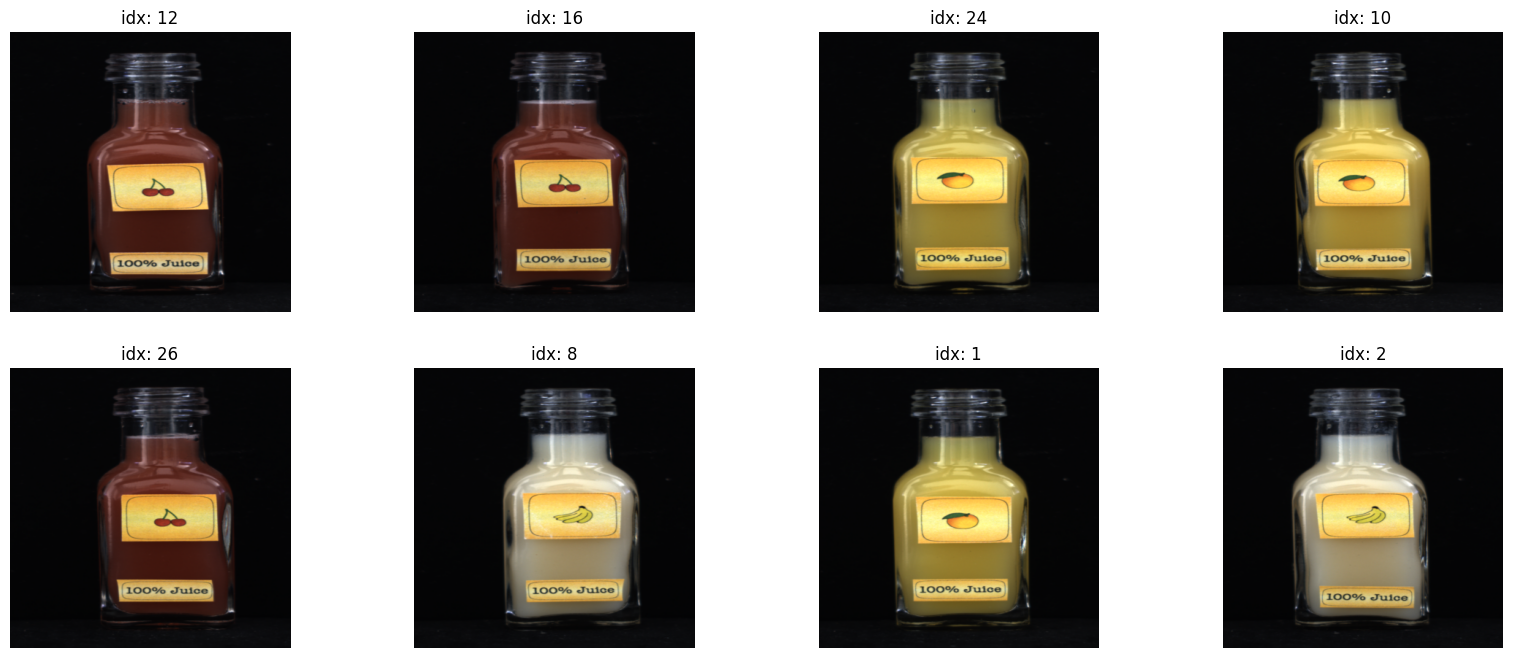

In [11]:
# sample 20 images & corresponding codebook indices
n_samples = 8
sampled_indices = np.random.choice(len(images), n_samples, replace=False)
sampled_images = images[sampled_indices].cpu().numpy()
sampled_ids_map = ids_map[sampled_indices]

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(2):
    for j in range(4):
        idx = i * 4 + j
        axes[i, j].imshow(sampled_images[idx].transpose(1, 2, 0))
        axes[i, j].set_title(f"idx: {sampled_indices[idx]}")
        axes[i, j].axis("off")

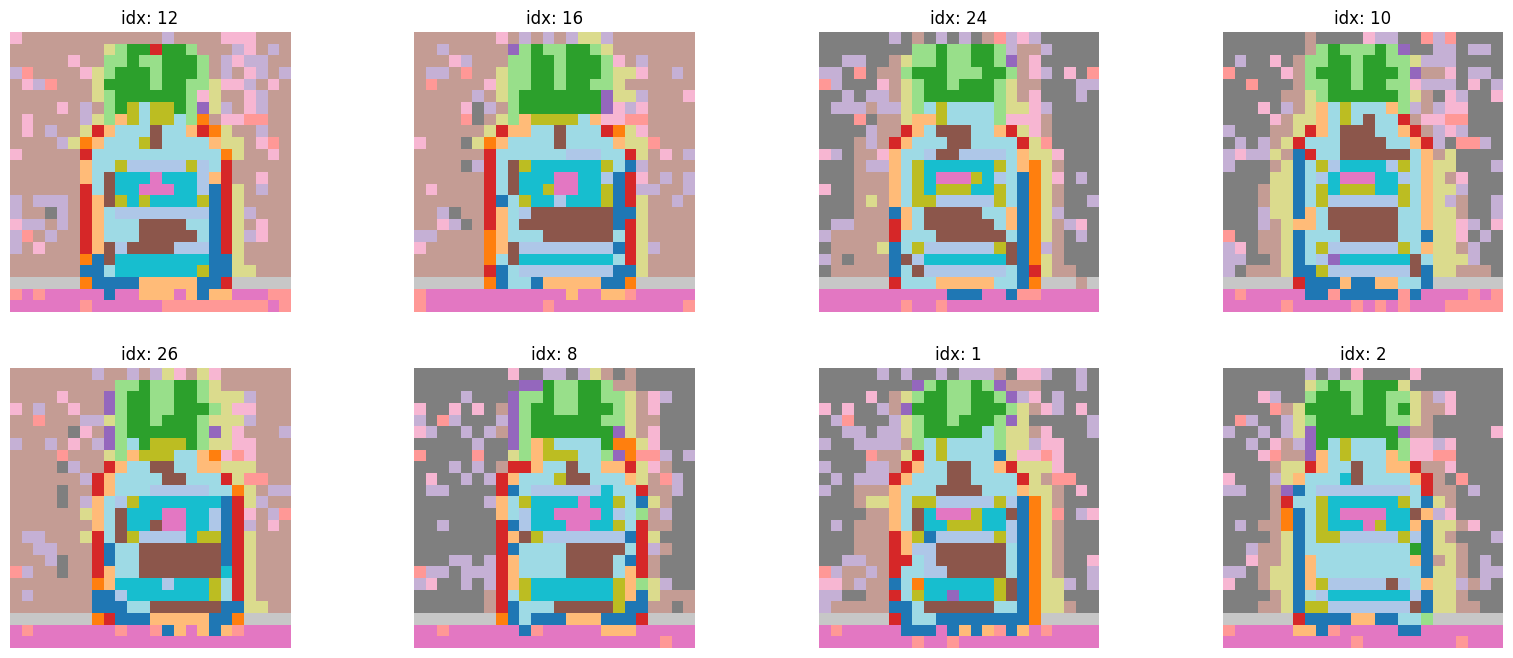

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(2):
    for j in range(4):
        idx = i * 4 + j
        axes[i, j].imshow(sampled_ids_map[idx], cmap="tab20")
        axes[i, j].set_title(f"idx: {sampled_indices[idx]}")
        axes[i, j].axis("off")